In [ ]:
import torch
import faiss
import faiss.contrib.torch_utils

res = faiss.StandardGpuResources()
config = faiss.GpuIndexFlatConfig()
config.device = 1
faiss_dim = 100
index = faiss.GpuIndexFlatL2(res, faiss_dim, config)


In [2]:
data = torch.randn(1000, faiss_dim).float().to('cuda:1')
index.add(data)

In [3]:
query = torch.randn(10, faiss_dim).float().to('cuda:1')

distances, indices, embeddings = index.search_and_reconstruct(query, 5)

In [4]:
print("distances", distances.shape)
print("indices", indices.shape)
print("embeddings", embeddings.shape)

distances torch.Size([10, 5])
indices torch.Size([10, 5])
embeddings torch.Size([10, 5, 100])


In [ ]:
import torch
from models.Memory import MemoryBankWithRetrieval
from data_provider.data_factory import data_provider
from argparse import Namespace

args = Namespace(
    task_name="long_term_forecast",
    is_training=1,
    model_id="ETTm1_96_192",
    model="PatchTST",
    data="ETTm1",
    root_path="./dataset/ETT-small",
    data_path="ETTm1.csv",
    features="M",
    target="OT",
    freq="h",
    checkpoints="./checkpoints/",
    seq_len=96,
    label_len=48,
    pred_len=192,
    seasonal_patterns="Monthly",
    inverse=False,
    mask_rate=0.25,
    anomaly_ratio=0.25,
    expand=2,
    d_conv=4,
    top_k=5,
    num_kernels=6,
    enc_in=7,
    dec_in=7,
    c_out=7,
    d_model=128,
    n_heads=2,
    e_layers=3,
    d_layers=1,
    d_ff=128,
    moving_avg=25,
    factor=3,
    distil=True,
    dropout=0.1,
    embed="timeF",
    activation="gelu",
    channel_independence=1,
    decomp_method="moving_avg",
    use_norm=1,
    down_sampling_layers=0,
    down_sampling_window=1,
    down_sampling_method=None,
    seg_len=96,
    num_workers=10,
    itr=1,
    train_epochs=10,
    batch_size=128,
    patience=5,
    learning_rate=0.0001,
    des="Exp",
    loss="MSE",
    lradj="type3",
    use_amp=False,
    use_gpu=True,
    gpu=0,
    gpu_type="cuda",
    use_multi_gpu=False,
    devices="0,1,2,3",
    p_hidden_dims=[128, 128],
    p_hidden_layers=2,
    use_dtw=False,
    augmentation_ratio=0,
    seed=2,
    jitter=False,
    scaling=False,
    permutation=False,
    randompermutation=False,
    magwarp=False,
    timewarp=False,
    windowslice=False,
    windowwarp=False,
    rotation=False,
    spawner=False,
    dtwwarp=False,
    shapedtwwarp=False,
    wdba=False,
    discdtw=False,
    discsdtw=False,
    extra_tag="",
    patch_len=16,
    fusion_mode="mean",
    w_trend=0.25,
    w_frequency=0.25,
    use_rag=True,
    num_retrieve=5,
)

args.device = torch.device("cuda:1")


def _get_data(flag):
    data_set, data_loader = data_provider(args, flag)
    return data_set, data_loader


memory_bank = MemoryBankWithRetrieval(
    seq_len=96,
    dim=7,
    pred_len=192,
    use_gpu=True,
    gpu_index=1,
)
train_data, train_loader = _get_data(flag="train")

memory_bank.load_dataset(train_loader)

train 34273
Memory bank built successfully. Index size: 34273, Store size: 34273


In [ ]:
import numpy as np
from utils.tools import visual_similar
import os

device = torch.device("cuda:0")
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float().to(device)
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)

    f_dim = -1 if args.features == "MS" else 0
    outputs = outputs[:, -args.pred_len :, f_dim:]
    batch_y = batch_y[:, -args.pred_len :, f_dim:].to(device)

    (
        similar_seqs,
        similar_seqs_mark_x,
        similar_seqs_gt,
        distances,
    ) = memory_bank.retrieve_similar(
        batch_x,
        k=5,
        iter=i,
    )

    # 可视化检索结果，前三相似的序列和gt高度重叠
    if similar_seqs is not None and i % 20 == 0:
        input = batch_x.detach().cpu().numpy()
        gt = batch_y.detach().cpu().numpy()
        similar_x = similar_seqs.detach().cpu().numpy()
        similar_gt = similar_seqs_gt.detach().cpu().numpy()
        # if train_data.scale and self.args.inverse:
        #     shape = input.shape
        #     input = train_data.inverse_transform(
        #         input.reshape(shape[0] * shape[1], -1)
        #     ).reshape(shape)
        #     similar_x = train_data.inverse_transform(
        #         similar_x.reshape(shape[0] * shape[1], -1)
        #     ).reshape(shape)
        real = np.concatenate((input[0, :, -1], gt[0, :, -1]), axis=0)
        similar = np.concatenate(
            (
                similar_x[0, :, :, -1],
                similar_gt[0, :, :, -1],
            ),
            axis=1,
        )
        visual_similar(
            real,
            similar,
            os.path.join("./similar", str(i) + ".png"),
        )

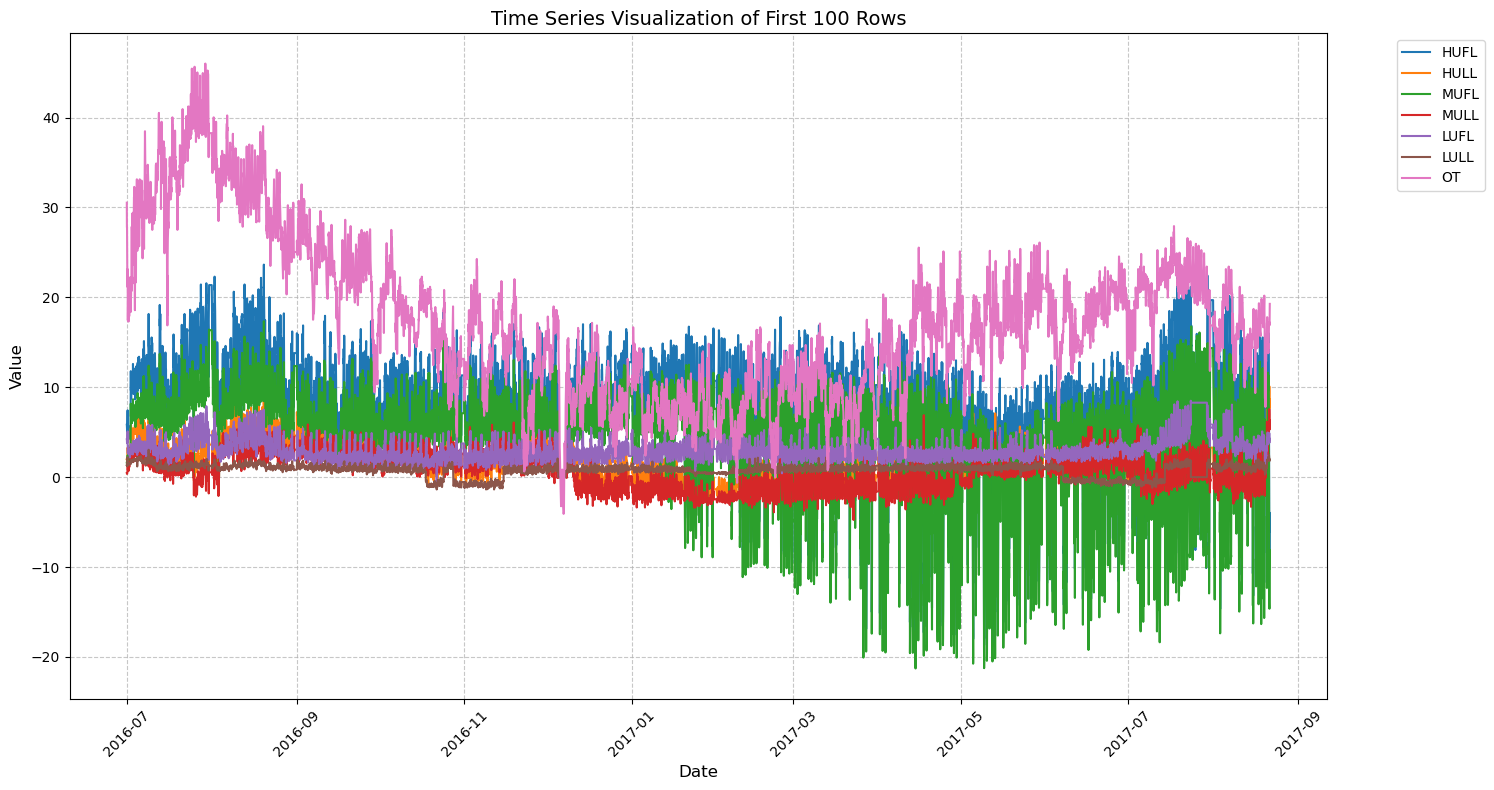

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据并指定日期列
df = pd.read_csv('dataset/ETT-small/ETTh1.csv', 
                 parse_dates=['date'], 
                 nrows=10000)  # 仅读取前100行

# 设置日期为索引
df.set_index('date', inplace=True)

# 创建画布和图形
plt.figure(figsize=(15, 8))

# 绘制所有数值列的折线图
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# 添加图表元素
plt.title('Time Series Visualization of First 100 Rows', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45)  # 旋转日期标签避免重叠
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例位置
plt.tight_layout()  # 自动调整布局
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格

# 显示图表
plt.show()

In [15]:
df["HUFL"].values[0:96]

array([ 5.82700014,  5.69299984,  5.15700006,  5.09000015,  5.3579998 ,
        5.62599993,  7.16699982,  7.43499994,  5.55900002,  4.55499983,
        4.95699978,  5.76000023,  4.68900013,  4.68900013,  5.09000015,
        5.09000015,  4.21999979,  4.75600004,  5.62599993,  5.4920001 ,
        5.3579998 ,  5.09000015,  4.82299995,  4.62200022,  5.22399998,
        5.15700006,  5.15700006,  5.15700006,  4.55499983,  5.42500019,
        5.4920001 ,  5.62599993,  5.55900002,  5.22399998,  9.91300011,
       11.78800011,  9.64500046, 10.38199997,  8.77400017, 10.44900036,
        9.84599972,  9.91300011, 10.64999962, 10.11400032,  9.97999954,
        9.31000042,  9.44400024,  9.44400024, 10.38199997,  9.77900028,
       10.38199997,  9.77900028, 10.71700001, 10.31499958, 12.59200001,
       11.11900043, 10.64999962, 10.04699993, 11.72099972, 12.12300014,
        9.97999954,  9.24300003, 10.18099976,  9.64500046,  9.77900028,
       11.11900043, 11.05200005, 10.7840004 , 11.18599987, 10.44